In [ ]:
# default_exp examples.multilabel_classification

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# examples.multilabel_classification

> This is an example of how to use blurr for multilabel classification tasks

In [ ]:
#export
import torch, nlp
from transformers import *

from fastai.text.all import *
from fastai.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.0
Using fastai 2.1.3
Using transformers 3.4.0


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


Let's start by building our `DataBlock`

In [ ]:
# creates a dataset with the first 10% of training set
raw_data = nlp.load_dataset('civil_comments', split='train[:1%]') 
len(raw_data)

Using custom data configuration default


18049

In [ ]:
toxic_df = pd.DataFrame(raw_data, columns=list(raw_data.features.keys()))
toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [ ]:
lbl_cols = list(toxic_df.columns[2:]); lbl_cols

['severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit']

In [ ]:
toxic_df = toxic_df.round({col: 0 for col in lbl_cols})
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0,0,0,0,0,0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0,0,0,0,0,0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0,0,0,0,0,0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0,0,0,0,0,0
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,0


For our huggingface model, let's used the distilled version of RoBERTa. This should allow us to train the model on bigger mini-batches without much performance loss.  Even on my 1080Ti, I should be able to train all the parameters (which isn't possible with the `roberta-base` model)

In [ ]:
task = HF_TASKS_ALL.SequenceClassification

pretrained_model_name = "distilroberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))

roberta
<class 'transformers.configuration_roberta.RobertaConfig'>
<class 'transformers.tokenization_roberta.RobertaTokenizer'>
<class 'transformers.modeling_roberta.RobertaForSequenceClassification'>


Note how we have to configure the `num_labels` to the number of labels we are predicting. Given that our labels are already encoded, we use a `MultiCategoryBlock` with encoded=True and vocab equal to the columns with our 1's and 0's.

In [ ]:
blocks = (
    HF_TextBlock(hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), 
    MultiCategoryBlock(encoded=True, vocab=lbl_cols)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), get_y=ColReader(lbl_cols), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(toxic_df, bs=16)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([16, 391]), torch.Size([16, 6]))

With our DataLoaders built, we can now build our `Learner` and train.  We'll use mixed precision so we can train with bigger batches

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[partial(accuracy_multi, thresh=0.2)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

learn.loss_func.thresh = 0.2
learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
learn.blurr_summary()

HF_BaseModelWrapper (Input shape: 16 x 391)
Layer (type)         Output Shape         Param #    Trainable 
Embedding            16 x 391 x 768       38,603,520 False     
________________________________________________________________
Embedding            16 x 391 x 768       394,752    False     
________________________________________________________________
Embedding            16 x 391 x 768       768        False     
________________________________________________________________
LayerNorm            16 x 391 x 768       1,536      True      
________________________________________________________________
Dropout              16 x 391 x 768       0          False     
________________________________________________________________
Linear               16 x 391 x 768       590,592    False     
________________________________________________________________
Linear               16 x 391 x 768       590,592    False     
______________________________________________________

In [ ]:
preds = model(b[0])
preds.logits.shape, preds

(torch.Size([16, 6]),
 SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1273,  0.1810,  0.0941,  0.1929,  0.0096, -0.2432],
         [ 0.1341,  0.1908,  0.0799,  0.1929,  0.0457, -0.2637],
         [ 0.1249,  0.1837,  0.0831,  0.1770,  0.0238, -0.2433],
         [ 0.1304,  0.1728,  0.1006,  0.1960,  0.0102, -0.2417],
         [ 0.1427,  0.1826,  0.0640,  0.1867,  0.0239, -0.2357],
         [ 0.1479,  0.1927,  0.0771,  0.1832,  0.0169, -0.2282],
         [ 0.1287,  0.1819,  0.0742,  0.1996,  0.0195, -0.2411],
         [ 0.1261,  0.1682,  0.0893,  0.1786,  0.0206, -0.2353],
         [ 0.1394,  0.1732,  0.0824,  0.1812,  0.0161, -0.2397],
         [ 0.1221,  0.1741,  0.0797,  0.1760,  0.0235, -0.2294],
         [ 0.1267,  0.1714,  0.0736,  0.1892,  0.0285, -0.2501],
         [ 0.1338,  0.1701,  0.0832,  0.1808,  0.0256, -0.2294],
         [ 0.1235,  0.1835,  0.0855,  0.1955,  0.0224, -0.2327],
         [ 0.1062,  0.1617,  0.0901,  0.1906,  0.0128, -0.2203],
         [ 0.1238,  0.183

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0012022644514217973)

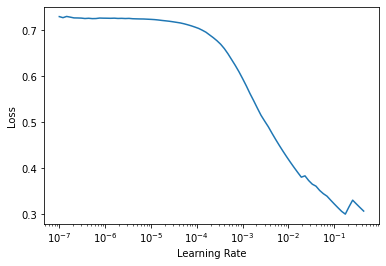

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.029054,0.036208,0.992749,01:10


SuggestedLRs(lr_min=1.4454397678775877e-09, lr_steep=4.897788077884435e-11)

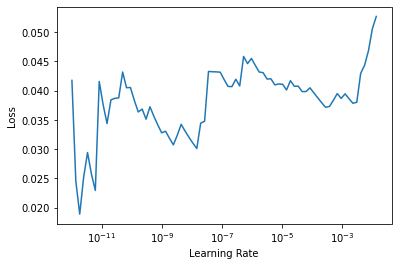

In [ ]:
learn.unfreeze()
learn.lr_find(suggestions=True, start_lr=1e-12)

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(1e-10, 4e-9))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.034936,0.036208,0.992749,01:55
1,0.033289,0.036208,0.992749,01:55


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,None,target
0,"As usual WW plumbing the depths for deeper meaning... that is unless it involves an issue on which they disagree then it is ridicule 24/7. Clever creating the Bundyland series complete with cartoon banner. Set the tone for the level of journalism to expect... journalism? ... fatastisticism. \n\nI did notice you soft pedaling the ridicule of David Fry identifying him as troubled. My guess is that has more to do with sympathy for his pot smoking withdrawl rants than respect for his politics. Respect is never a factor with liberals as evidenced by your series of vapid caricatures. \n\nDid you happen to see the stories actual journalists did on Refuge mis-managment, fires, floods, and the millions of Carp that are harassing the birds away from the Bird Refuge? The stories of arbitrary miss-management that are driving unemployment ever higher in eastern Oregon. Curry County Sheriff turning in his badge in frustration for lack of resources dud to dwindling tax base engineered by arbitrary over reaching Federal Government policies. Or how about the thousands of miles of roads proposed to be removed from Oregon wild lands, cutting off public and fire access? What is the one issue the people of Oregon demand universally? Access to the wild lands? You are not reporting that it is being taken away. More closed roads. More illegal Federal Police, guns drawn, stops... as reported by the Sheriff of Grant County. \n\nI suspect the real problem was real people you couldn't care less about were articulate, were actual victims, and made rational arguments you could not respond to. The exact opposite of the great unbathed OWS movement, apart from the paid organizers, that held downtown Portland hostage and trashed 3 park blocks for 3 weeks. \n\nShame on you. You missed some really great stories and even greater people... people who don't drink $5 cups of coffee.",,[]
1,"""I don’t expect to see that again in my lifetime, but I’d love to see the city on a clear path to return to those days..."" Yawn. Locals have appreciated downtown revitalization that HAS occurred with a plethora of offices, cafes, pubs, dance studios, galleries, boutiques, book stores, music halls, nonprofits, theaters and uniquely Eugene venues. \n\nRespect the deed restriction. The tribes have spoken: be a good sport and shift your plans any place except to 1 of OUR last 2 open public meeting spaces. As George Brown said: the only element lacking is imagination. A building here, as many commented elsewhere, would suffocate the last feeling of free space that exists. \n \nAffordable housing there? what a joke! Commercial developers know that this downtown zone is the most EXPENSIVE area in which to build rentals (fire codes etc.) That's why a popular nonprofit developer would not touch the space next to WOW with a 10 ft. pole years ago. A vibrant movement is blossoming here. Let it be!",,[]


In [ ]:
learn.loss_func.thresh = 0.02

In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

((#1) ['insult'],
 tensor([False, False, False,  True, False, False]),
 tensor([3.6479e-05, 5.5334e-03, 3.2000e-04, 3.9195e-02, 2.4155e-03, 1.9955e-03]))

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01e_data-summarization.ipynb.
Converted 01z_data-language-modeling.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02e_modeling-summarization.ipynb.
Converted 02z_modeling-language-modeling.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
